In [ ]:
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import requests
import json
import pandas as pd
import numpy as np
import time

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Naive Bayes - Restructuring Data

In [ ]:
# Get list of all 100 senators
from bs4 import BeautifulSoup
import requests

url = 'https://www.socialseer.com/resources/us-senator-twitter-accounts/'
req = requests.get(url)
html = req.text
soup = BeautifulSoup(html, 'html.parser')

# Get twitter handles
body = soup.find('tbody')
td = body.find('td')
children = body.findChildren(recursive=False)
twitter_handles = []

# Loop through children
for child in children:
  if child.a:
    twitter_handles.append(child.a.text)

# Removing senators who no longer are in senate, or who changed their handles senatorsanders
remove = ['SenKamalaHarris', 'SenBennetCO', 'JeffFlake', 'SenJonKyl', 'SenateMajLdr', 'SenDougJones', 'senatorsanders']
twitter_handles = [keep for keep in twitter_handles if keep not in remove]
twitter_handles.extend(['SenatorBennet', 'AlexPadilla4CA', 'SenatorSinema', 'SenMarkKelly', 'LeaderMcConnell', 'SenTuberville', 'BernieSanders'])

In [ ]:
# Get user id of each senator's username

bearer_token = 'AAAAAAAAAAAAAAAAAAAAAKWfUAEAAAAAVlRCaBC9G2XcfK12sEaYBSFMQFo%3D2Ras8AORAGYkWjjjZpicOkZWBShWS96mk74MFTDi6zYZLzqKAj'
headers = {'Authorization':('Bearer '+ bearer_token)}

def get_user_data(username):
  url = "https://api.twitter.com/2/users/by/username/" + username
  response = requests.request("GET", url, headers=headers)
  json_data_test = json.loads(response.text)
  print(json_data_test)
  return json_data_test['data']

In [ ]:
# Get user id of each senator's username

# bearer_token = 'AAAAAAAAAAAAAAAAAAAAAKWfUAEAAAAAVlRCaBC9G2XcfK12sEaYBSFMQFo%3D2Ras8AORAGYkWjjjZpicOkZWBShWS96mk74MFTDi6zYZLzqKAj'
# headers = {'Authorization':('Bearer '+ bearer_token)}

def get_user_data(username):
  url = "https://api.twitter.com/2/users/by/username/" + username
  response = requests.request("GET", url, headers=headers)
  json_data_test = json.loads(response.text)
  print(json_data_test)

  return json_data_test['data']

In [ ]:
# Get tweets 
def get_tweets_new(username):
  user_data = get_user_data(username)
  bearer_token = 'AAAAAAAAAAAAAAAAAAAAAKWfUAEAAAAAVlRCaBC9G2XcfK12sEaYBSFMQFo%3D2Ras8AORAGYkWjjjZpicOkZWBShWS96mk74MFTDi6zYZLzqKAj'
  headers = {'Authorization':('Bearer '+ bearer_token)}

  n = 5                        
  max_results = 100               
  total_retrieved = 0               
  next_token = ""        
  json_data = {'data': []}     

  df = pd.DataFrame(columns=['id', 'text', 'retweets', 'likes', 'replies', 'quotes', 'day_week', 'time_day', 'author_name'])    
  df.set_index('id', inplace=True)  

  # Gathering tweets
  while total_retrieved < n:

    if next_token == "":
      url = f"https://api.twitter.com/2/users/{user_data['id']}/tweets?exclude=retweets,replies&max_results={max_results}"
    else:
      url = f"https://api.twitter.com/2/users/{user_data['id']}/tweets?exclude=retweets,replies&max_results={max_results}&pagination_token={next_token}"

    # Extra paramteres
    url += f"&tweet.fields=public_metrics,created_at"
    
    # Make request to Twitter API enpoint - returns json object
    response = requests.request("GET", url, headers=headers)
    try:
      json_data = json.loads(response.text)

      for tweet in json_data['data']:
        tweet_id = tweet['id']
        text = tweet['text']
        retweet_count = tweet['public_metrics']['retweet_count']
        like_count = tweet['public_metrics']['like_count']
        reply_count = tweet['public_metrics']['reply_count']
        quote_count = tweet['public_metrics']['quote_count']
        day_week = tweet['created_at'][10]
        hour_day = tweet['created_at'][11:13]
        name = user_data['username']
        df.loc[tweet_id] = [text, retweet_count, like_count, reply_count, quote_count, day_week, hour_day, name]

      try:
        next_token = json_data['meta']['next_token']  # Retreive next_token in order to loop through more than 100 tweets at a time
      except:
        break
        
      total_retrieved += 1
    
    except:
      print(response.text)
      time.sleep(60)

  return df

In [ ]:
dataframe = [get_tweets_new(handle) for handle in twitter_handles]  
df = pd.concat(dataframe)
df.head()

{'data': {'id': '21111098', 'name': 'Richard Shelby', 'username': 'SenShelby'}}
{'data': {'id': '18061669', 'name': 'Sen. Lisa Murkowski', 'username': 'lisamurkowski'}}
{'data': {'id': '2891210047', 'name': 'Sen. Dan Sullivan', 'username': 'SenDanSullivan'}}
{'data': {'id': '968650362', 'name': 'Tom Cotton', 'username': 'SenTomCotton'}}
{'data': {'id': '5558312', 'name': 'Senator John Boozman', 'username': 'JohnBoozman'}}
{'data': {'id': '476256944', 'name': 'Senator Dianne Feinstein', 'username': 'SenFeinstein'}}
{'data': {'id': '235217558', 'name': 'Cory Gardner', 'username': 'SenCoryGardner'}}
{'data': {'id': '150078976', 'name': 'Chris Murphy', 'username': 'ChrisMurphyCT'}}
{'data': {'id': '278124059', 'name': 'Richard Blumenthal', 'username': 'SenBlumenthal'}}
{'data': {'id': '249787913', 'name': 'Senator Tom Carper', 'username': 'SenatorCarper'}}
{'data': {'id': '15324851', 'name': 'Senator Chris Coons', 'username': 'ChrisCoons'}}
{'data': {'id': '20597460', 'name': 'Bill Nelson'

,text,retweets,likes,replies,quotes,day_week,time_day,author_name
id,,,,,,,,
1467561104683511813,I am very saddened to learn of the passing of ...,8,39,4,0,T,18,SenShelby
1466477912450818055,"Despite the crisis at our southern border, Pre...",10,29,29,0,T,18,SenShelby
1465404007044816897,Congratulations to @UofAlabama’s Nicholas Haye...,2,17,3,0,T,19,SenShelby
1463901898424082443,Happy #Thanksgiving! Today and every day I am ...,5,21,8,0,T,16,SenShelby
1463216831800430599,This $32M @USDA investment is excellent news f...,1,5,10,1,T,18,SenShelby


In [ ]:
df.shape

(48625, 8)

In [ ]:
df.to_csv('./text_all_senators_updated.csv')

# Working with Naive Bayes DataFame - (All senators csv)

## Generic Stop Words

In [ ]:
# df = pd.read_csv('./Datasets/five_senators.csv')
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/text_all_senators.csv')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

target_names = df['author_name'].unique()
sw_list = stopwords.words('english')

X = df['text']
y = df['author_name']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

model = make_pipeline(TfidfVectorizer(stop_words=sw_list), MultinomialNB())
model.fit(X_train, y_train)
labels = model.predict(X_test)


In [ ]:
# matrix is not readable w/ 100 different label classes
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=target_names, yticklabels=target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [ ]:
output_df = pd.DataFrame({'Actual': y_test, 'Predicted': labels, 'Result': labels==y_test})

results = output_df['Result'].value_counts()
accuracy = results[1]/(results[0]+results[1])
print(f'Accuracy: {round(accuracy,6) * 100}%')
output_df.head()

Accuracy: 44.886199999999995%


,Actual,Predicted,Result
33759,SenBobCasey,PattyMurray,False
7933,maziehirono,SenWarren,False
43256,Sen_JoeManchin,Sen_JoeManchin,True
44510,SenRonJohnson,SenTedCruz,False
38390,JohnCornyn,SenatorCarper,False


In [ ]:
def predict_author(text, model=model):
    pred = model.predict([text])
    # target_names = np.unique(y_train)
    return pred[0]

predict_author('It is time that the billionaire class pays its share in taxes')

'SenWarren'

## W/ More Stop Words

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords

target_names = df['author_name'].unique()
sw_list = stopwords.words('english')
# sw_list.extend(['co', 'http', 'https'])

X = df['text']
y = df['author_name']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

model = make_pipeline(TfidfVectorizer(stop_words=sw_list), MultinomialNB())
model.fit(X_train, y_train)
labels = model.predict(X_test)



# Print results
output_df = pd.DataFrame({'Actual': y_test, 'Predicted': labels, 'Result': labels==y_test})
results = output_df['Result'].value_counts()
accuracy = results[1]/(results[0]+results[1])
print(f'Accuracy: {round(accuracy,6) * 100}%')
output_df.head()

Accuracy: 44.1322%


,Actual,Predicted,Result
8980,SenatorRisch,RoyBlunt,False
38121,SenAlexander,SenWarren,False
14222,SenJohnKennedy,SenJohnKennedy,True
34604,SenToomey,SenJackReed,False
18104,SenGaryPeters,SenGaryPeters,True


Doing 10 runs for each type (normal stopwords and added stopwords)

In [ ]:
final_accuracy = []
target_names = df['author_name'].unique()
sw_list = stopwords.words('english')
sw_list.extend(['co', 'http', 'https'])

for _ in range(10):

  X = df['text']
  y = df['author_name']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

  model = make_pipeline(TfidfVectorizer(stop_words=sw_list), MultinomialNB())
  model.fit(X_train, y_train)
  labels = model.predict(X_test)



  # Print results
  output_df = pd.DataFrame({'Actual': y_test, 'Predicted': labels, 'Result': labels==y_test})
  results = output_df['Result'].value_counts()
  accuracy = results[1]/(results[0]+results[1])
  final_accuracy.append(accuracy)
  # print(f'Accuracy: {round(accuracy,6) * 100}%')
  # output_df.head()

print(f'Accuracy: {round(sum(final_accuracy)/len(final_accuracy),6) * 100}%')

Accuracy: 43.797599999999996%


## Other naive bayes

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/text_all_senators.csv')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import numpy as np

target_names = df['author_name'].unique()
sw_list = stopwords.words('english')
# sw_list.extend(['co', 'http', 'https'])

X = df['text']
y = df['author_name']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

model = make_pipeline(TfidfVectorizer(stop_words=sw_list), MultinomialNB())
model.fit(X_train,y_train)
labels = model.predict(X_test)



# Print results
output_df = pd.DataFrame({'Actual': y_test, 'Predicted': labels, 'Result': labels==y_test})
results = output_df['Result'].value_counts()
accuracy = results[1]/(results[0]+results[1])
print(f'Accuracy: {round(accuracy,6) * 100}%')
output_df.head()

Accuracy: 43.9471%


,Actual,Predicted,Result
17600,SenWarren,SenWarren,True
14927,SenAngusKing,SenAngusKing,True
17186,SenWarren,JerryMoran,False
25187,SenatorHassan,SenatorHassan,True
16446,SenatorCardin,SenatorCardin,True


# LDA Dataset Preprocessing (3rd data set) 

## LDA Text Model

Need to do some more cleaning of text and topics ...

In [ ]:
!pip install pyLDAvis
!pip install pyLDAvis.gensim
!pip install logging
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download en_core_web_sm

In [ ]:
import sys
import re
import numpy as np
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['co', 'american', 'amp', 'make', 'amp', 'country', 'http', 'https'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/text_all_senators.csv')
df.head()

,id,text,retweets,likes,replies,quotes,day_week,time_day,author_name
0,1461387699345145856,As the longest serving member and former chair...,7,9,8,1,T,17,SenShelby
1,1461387697914888193,After reviewing Dr. Omarova’s record and heari...,8,27,13,4,T,17,SenShelby
2,1461113415418662920,This is excellent news for UAB and patient car...,3,16,7,0,T,23,SenShelby
3,1460749779647012868,The crisis at our southern border continues. M...,37,99,43,4,T,23,SenShelby
4,1460744180565688323,Today I met with @federalreserve Chair Jay Pow...,7,21,19,2,T,22,SenShelby


In [ ]:
def sent_to_words(sentences):
  for sent in sentences:
    sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
    sent = re.sub('\s+', ' ', sent)  # remove newline chars
    sent = re.sub("\'", "", sent)  # remove single quotes
    sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
    yield(sent)  

# Convert each tweet to a list of cleaned words and add to a master list
data = df.text.values.tolist()
data_words = list(sent_to_words(data))
for tweet in data_words[:5]: # print the first :n tweet word lists
  print(tweet)

['as', 'the', 'longest', 'serving', 'member', 'and', 'former', 'chairman', 'of', 'the', 'senate', 'banking', 'committee', 'understand', 'the', 'importance', 'of', 'the', 'role', 'the', 'comptroller', 'of', 'the', 'currency', 'serves', 'in', 'regulating', 'and', 'supervising', 'national', 'banks', 'dr', 'omarova', 'is', 'not', 'qualified', 'for', 'this', 'position']
['after', 'reviewing', 'dr', 'omarova', 'record', 'and', 'hearing', 'her', 'testimony', 'today', 'have', 'grave', 'concerns', 'about', 'her', 'views', 'and', 'ability', 'to', 'lead', 'the', 'occ', 'in', 'an', 'impartial', 'manner', 'will', 'not', 'support', 'her', 'nomination']
['this', 'is', 'excellent', 'news', 'for', 'uab', 'and', 'patient', 'care', 'in', 'alabama', 'look', 'forward', 'to', 'seeing', 'the', 'positive', 'impacts', 'this', 'cutting', 'edge', 'facility', 'will', 'have', 'on', 'the', 'day', 'to', 'day', 'lives', 'of', 'alabamians', 'and', 'the', 'local', 'economy', 'https', 'co', 'sqyio', 'pwy']
['the', 'cris

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
  """Remove Stopwords, Form Bigrams, Trigrams and perform Lemmatization"""
  texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
  texts = [bigram_mod[doc] for doc in texts]
  texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
      
  texts_out = []
  nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) 
      
  for sent in texts:
    doc = nlp(" ".join(sent)) 
    texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        
  # remove stopwords once more after lemmatization
  texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
  return texts_out
  
data_ready = process_words(data_words)  # processed Text Data
for tweet in data_ready[:5]:
  print(tweet)

['longest_serving', 'member', 'former', 'chairman', 'understand', 'importance', 'role', 'comptroller', 'currency', 'serve', 'regulate', 'supervise', 'national', 'bank', 'qualified', 'position']
['review', 'record', 'hear', 'testimony', 'today', 'grave', 'concern', 'view', 'ability', 'lead', 'impartial', 'manner', 'support', 'nomination']
['excellent', 'news', 'patient', 'see', 'positive', 'impact', 'day', 'live', 'alabamian', 'local', 'economy', 'sqyio']
['continue', 'meanwhile', 'want', 'pay', 'subject', 'tolerance', 'policy', 'contrast', 'soldier', 'kill', 'family', 'receive']
['today', 'meet', 'discuss', 'potential', 'renomination', 'monetary', 'policy', 'inflation', 'believe', 'big', 'challenge', 'deeply_concerne', 'inflation', 'already', 'boat']


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create corpus
corpus = [id2word.doc2bow(text) for text in data_ready]

# Add new features to original dataset
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                      id2word=id2word, 
                                      num_topics=6, 
                                      chunksize=20, 
                                      passes=5,
                                      per_word_topics=True)

df_topics = df.copy()

num_topics = len(lda_model.get_topics()) # store the number of topics from the last model
for col in range(num_topics): # generate a new column for each topic
  df_topics[f'topic_{col + 1}'] = 0.0
  
# Store the topic score and dominant topic
for i, words in enumerate(data_ready):
  doc = lda_model[id2word.doc2bow(words)] # generate a corpus for this document set of words
  
  for j, score in enumerate(doc[0]): # for each document in the corpus
    # Get the topic score and store it in the appropriate column
    df_topics.iat[i, (len(df_topics.columns) - ((num_topics) - score[0]))] = score[1]

df_topics.head()

,id,text,retweets,likes,replies,quotes,day_week,time_day,author_name,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
0,1461387699345145856,As the longest serving member and former chair...,7,9,8,1,T,17,SenShelby,0.079437,0.000000,0.157755,0.000000,0.000000,0.733328
1,1461387697914888193,After reviewing Dr. Omarova’s record and heari...,8,27,13,4,T,17,SenShelby,0.011148,0.011161,0.079795,0.795078,0.011115,0.091702
2,1461113415418662920,This is excellent news for UAB and patient car...,3,16,7,0,T,23,SenShelby,0.094720,0.763823,0.012947,0.012831,0.102838,0.012842
3,1460749779647012868,The crisis at our southern border continues. M...,37,99,43,4,T,23,SenShelby,0.012835,0.012841,0.314966,0.012833,0.521006,0.125519
4,1460744180565688323,Today I met with @federalreserve Chair Jay Pow...,7,21,19,2,T,22,SenShelby,0.010435,0.371630,0.149368,0.010438,0.010437,0.447692


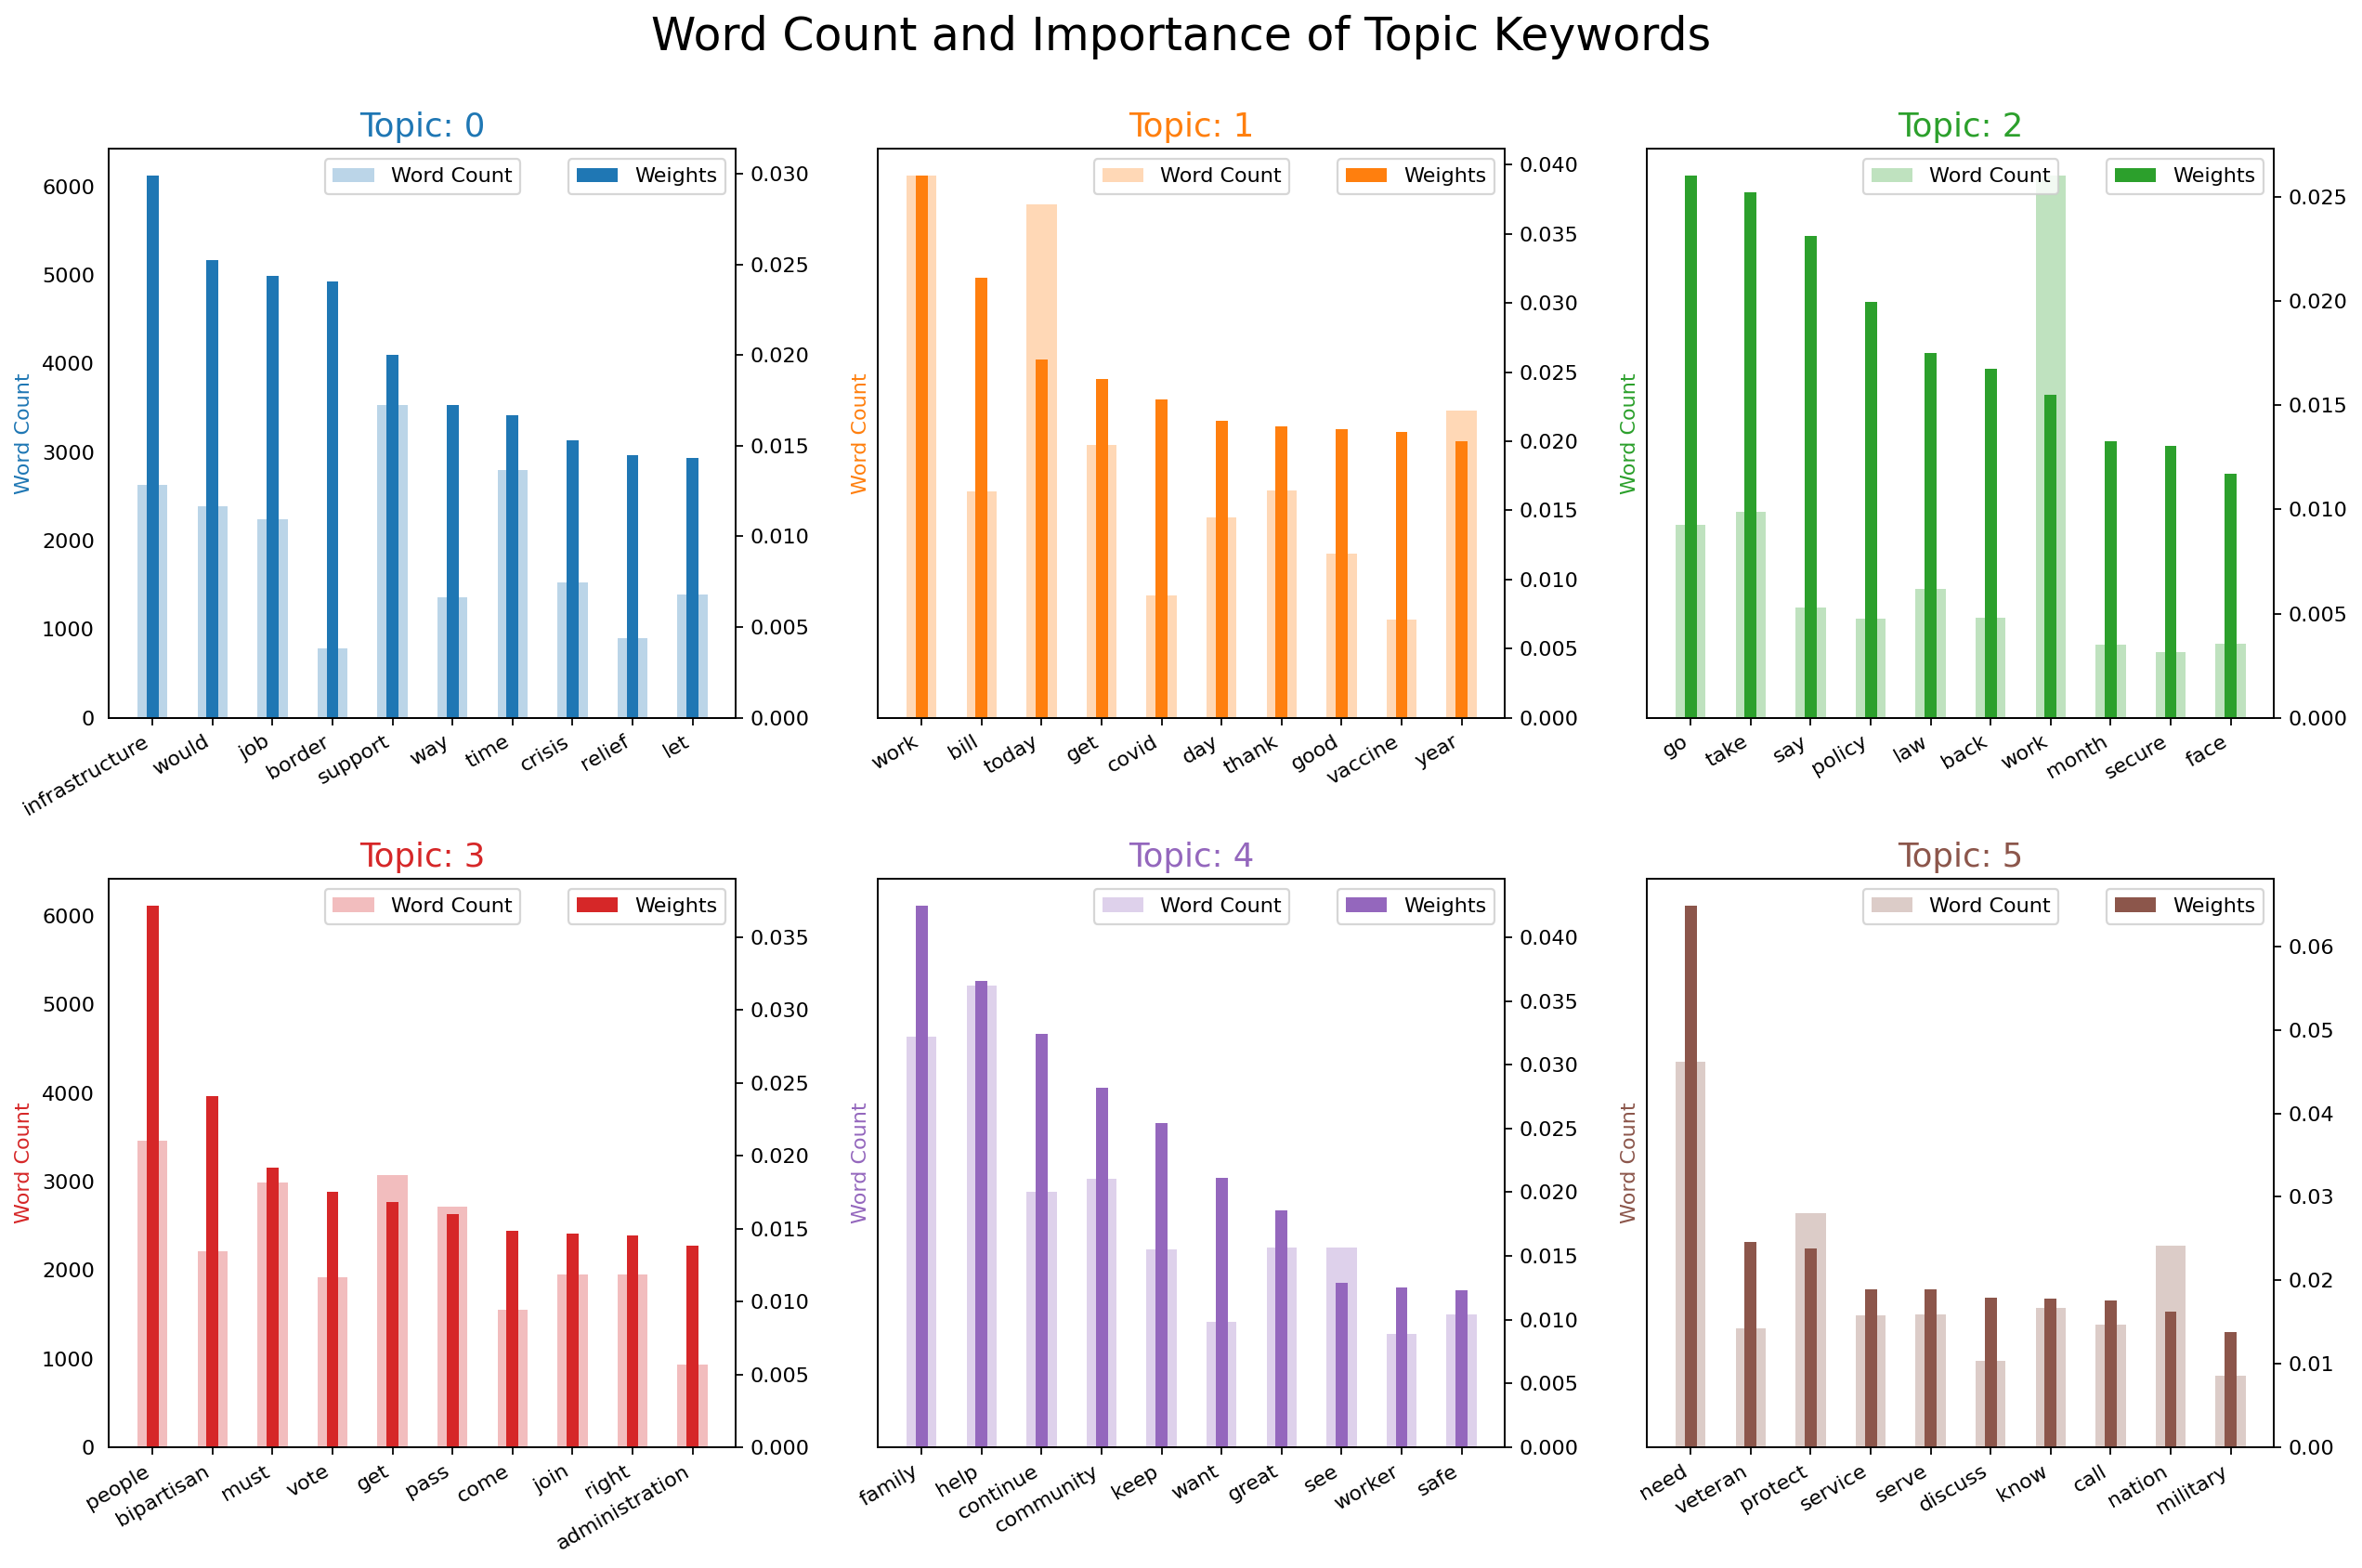

In [ ]:
# Bar chart of word counts for each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from collections import Counter


topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 3, figsize=(16,10), sharey=True, dpi=160)

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    # ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper center'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [ ]:
df_topics.to_csv('6topics_data.csv')

## 3rd Dataset - Running models

In [ ]:
# Run scikit learn MLP model on the new dataset
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Copy dataframe
df_topics_mlp = df_topics.copy()
X = df_topics_mlp.drop(columns=['id', 'text', 'author_name', 'day_week', 'time_day']) # keep day_week and time_day in future models
y = df_topics_mlp['author_name']


# Normailze dataframe
scaler = preprocessing.StandardScaler().fit(X)
X_normalized = scaler.transform(X)


# Min max normalization
min_max_scaler = preprocessing.MinMaxScaler()
X_min_max = min_max_scaler.fit_transform(X)

# Split and train MLP
# X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2) # gaussian
X_train, X_test, y_train, y_test = train_test_split(X_min_max, y, test_size=0.2) # min max
clf = MLPClassifier(max_iter=300).fit(X_train, y_train)
clf.score(X_test, y_test)

In [ ]:
# Run scikit learn MLP model on the new dataset
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Copy dataframe
df_topics_mlp = df_topics.copy()
X = df_topics_mlp.drop(columns=['id', 'text', 'author_name', 'day_week', 'time_day']) # keep day_week and time_day in future models
y = df_topics_mlp['author_name']


# Normailze dataframe
scaler = preprocessing.StandardScaler().fit(X)
X_normalized = scaler.transform(X)


# Min max normalization
min_max_scaler = preprocessing.MinMaxScaler()
X_min_max = min_max_scaler.fit_transform(X)

# Split and train MLP
# X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2) # gaussian
X_train, X_test, y_train, y_test = train_test_split(X_min_max, y, test_size=0.2) # min max
clf = MLPClassifier(max_iter=300).fit(X_train, y_train)
clf.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


0.09953727506426735

In [ ]:
mlp_sk = MLPClassifier(learning_rate='constant', learning_rate_init=0.15, hidden_layer_sizes=(30), momentum=0.65, activation='logistic', max_iter=1000,
                       n_iter_no_change=20, solver='sgd').fit(X_train, y_train)
mlp_sk.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


0.14118251928020564

## Second stab at improving model

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/12_topics_df.csv')
df.shape

(48625, 22)

In [ ]:
df_test = df.copy()

df_test.drop(columns=['Unnamed: 0', 'day_week', 'text', 'id'], inplace=True)
df_test.head()

,retweets,likes,replies,quotes,time_day,author_name,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12
0,7,9,8,1,17,SenShelby,0.0,0.144758,0.225497,0.075525,0.079278,0.000000,0.075555,0.000000,0.000000,0.144074,0.000000,0.227535
1,8,27,13,4,17,SenShelby,0.0,0.100358,0.000000,0.000000,0.000000,0.077381,0.000000,0.000000,0.000000,0.000000,0.691082,0.083559
2,3,16,7,0,23,SenShelby,0.0,0.000000,0.438648,0.141527,0.000000,0.000000,0.000000,0.255297,0.000000,0.000000,0.127490,0.000000
3,37,99,43,4,23,SenShelby,0.0,0.000000,0.000000,0.302265,0.067809,0.446784,0.000000,0.076651,0.000000,0.070031,0.000000,0.000000
4,7,21,19,2,22,SenShelby,0.0,0.078750,0.000000,0.000000,0.000000,0.062978,0.000000,0.000000,0.064142,0.000000,0.757093,0.000000


In [ ]:
X = df_test.drop(columns=['author_name'])
X = X[X.columns[:-6]]
y = df_test['author_name']

X['author_name'] = y

X.head()


,retweets,likes,replies,quotes,time_day,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,author_name
0,7,9,8,1,17,0.0,0.144758,0.225497,0.075525,0.079278,0.000000,SenShelby
1,8,27,13,4,17,0.0,0.100358,0.000000,0.000000,0.000000,0.077381,SenShelby
2,3,16,7,0,23,0.0,0.000000,0.438648,0.141527,0.000000,0.000000,SenShelby
3,37,99,43,4,23,0.0,0.000000,0.000000,0.302265,0.067809,0.446784,SenShelby
4,7,21,19,2,22,0.0,0.078750,0.000000,0.000000,0.000000,0.062978,SenShelby


In [ ]:
def bin_time(row):
    if row['time_day'] >= 0 and row['time_day'] < 7:
        return 'midnight'
    if row['time_day'] >= 7 and row['time_day'] < 12:
        return 'morning'
    if row['time_day'] >= 12 and row['time_day'] < 18:
        return 'afternoon'
    return 'night'

df_bin = df_test.copy()
df_bin['time_day'] = df_bin.apply(lambda row: bin_time(row), axis=1)

df_bin.head()

,id,retweets,likes,replies,quotes,time_day,author_name,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12
0,1461387699345145856,7,9,8,1,afternoon,SenShelby,0.0,0.144758,0.225497,0.075525,0.079278,0.000000,0.075555,0.000000,0.000000,0.144074,0.000000,0.227535
1,1461387697914888193,8,27,13,4,afternoon,SenShelby,0.0,0.100358,0.000000,0.000000,0.000000,0.077381,0.000000,0.000000,0.000000,0.000000,0.691082,0.083559
2,1461113415418662920,3,16,7,0,night,SenShelby,0.0,0.000000,0.438648,0.141527,0.000000,0.000000,0.000000,0.255297,0.000000,0.000000,0.127490,0.000000
3,1460749779647012868,37,99,43,4,night,SenShelby,0.0,0.000000,0.000000,0.302265,0.067809,0.446784,0.000000,0.076651,0.000000,0.070031,0.000000,0.000000
4,1460744180565688323,7,21,19,2,night,SenShelby,0.0,0.078750,0.000000,0.000000,0.000000,0.062978,0.000000,0.000000,0.064142,0.000000,0.757093,0.000000


Dummy encoding categorical

In [ ]:
# Run scikit learn MLP model on the new dataset
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Copy dataframe
df_topics_mlp = df_bin.copy()

# Dummy encode the categorical variables 
for col in df_topics_mlp:
  if col != 'author_name':
    if not pd.api.types.is_numeric_dtype(df_topics_mlp[col]):
      df_topics_mlp = pd.get_dummies(df_topics_mlp, columns=[col], drop_first=True)


# Split features and label
X = df_topics_mlp.drop(columns=['id', 'author_name']) # keep day_week and time_day in future models
y = df_topics_mlp['author_name']


Not dummy encoding

In [ ]:
# Run scikit learn MLP model on the new dataset
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Copy dataframe
df_topics_mlp = df_bin.copy()

# Dummy encode the categorical variables 
# for col in df_topics_mlp:
#   if col != 'author_name':
#     if not pd.api.types.is_numeric_dtype(df_topics_mlp[col]):
#       df_topics_mlp = pd.get_dummies(df_topics_mlp, columns=[col], drop_first=True)


# Split features and label
X = df_topics_mlp.drop(columns=['id', 'author_name', 'time_day']) # keep day_week and time_day in future models
y = df_topics_mlp['author_name']

In [ ]:
# Normailze dataframe
scaler = preprocessing.StandardScaler().fit(X)
X_normalized = scaler.transform(X)


# Min max normalization
min_max_scaler = preprocessing.MinMaxScaler()
X_min_max = min_max_scaler.fit_transform(X)

# Split and train MLP
# X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2) # gaussian
X_train, X_test, y_train, y_test = train_test_split(X_min_max, y, test_size=0.2) # min max
# clf = MLPClassifier(max_iter=300).fit(X_train, y_train)
clf = MLPClassifier(learning_rate='constant', learning_rate_init=0.15, hidden_layer_sizes=(60), momentum=0.65, activation='relu', max_iter=500,
                       n_iter_no_change=20, solver='sgd').fit(X_train, y_train)
clf.score(X_test, y_test)

0.06570694087403599

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

X_min_max = pd.DataFrame(MinMaxScaler().fit_transform(X))

X_train, X_test, y_train, y_test = train_test_split(X_min_max, y, test_size=0.2)

knn = KNeighborsClassifier(n_neighbors=25, weights='distance')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
score = metrics.accuracy_score(y_test, y_pred)
print(f'Accuracy: \t {round(score, 5)*100}%')

Accuracy: 	 3.157%


In [ ]:
from sklearn.svm import SVC

# X_train, X_test, y_train, y_test = train_test_split(X_min_max, y, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

SVC_model = SVC()
SVC_model.fit(X_train, y_train)
SVC_prediction = SVC_model.predict(X_test)
print(metrics.accuracy_score(SVC_prediction, y_test))

0.0458611825192802


In [ ]:
from sklearn import tree
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf_sk = tree.DecisionTreeClassifier(criterion='entropy', min_samples_leaf=2, min_impurity_decrease=.0001)

clf_sk = clf_sk.fit(X_train, y_train)

accuracy = clf_sk.score(X_test, y_test)
print(f'Accuracy of model: {round(accuracy,6)*100}%')

Accuracy of model: 8.390699999999999%


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# clf = RandomForestClassifier(n_estimators=10, criterion='entropy', min_samples_leaf=5, min_impurity_decrease=.0001)
clf = RandomForestClassifier(n_estimators=10)
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print(f'Accuracy of model: {round(accuracy,6)*100}%')

Accuracy of model: 10.539800000000001%


# Automating Pipeline to test models

## Pipeline Methods

In [ ]:
# Data Processing Methods

def get_data(url, col_drop):
  import pandas as pd
  pd.set_option('display.max_columns', 20)
  df = pd.read_csv(url)
  for col in col_drop:
    try:
      df.drop(columns=col, inplace=True)
    except:
      pass
  return df

def drop_missing_columns(df, cutoff=0.55):
  import pandas as pd
  for col in df:
    if (df[col].isna().sum() / len(df)) >= cutoff:
      df.drop(columns=[col], inplace=True)
  return df


def binning_categorical(df, cutoff=0.10):
  import pandas as pd

  for col in df:
    if not pd.api.types.is_numeric_dtype(df[col]):
      for group, count in df[col].value_counts().iteritems():
        if count/len(df) < cutoff:
          df.loc[df[col] == group, col] = 'Other'
  return df


def bin_time(row):
    if row['time_day'] >= 0 and row['time_day'] < 7:
        return 'midnight'
    if row['time_day'] >= 7 and row['time_day'] < 12:
        return 'morning'
    if row['time_day'] >= 12 and row['time_day'] < 18:
        return 'afternoon'
    return 'night'


def dummy_encode(df):
  import pandas as pd
  for col in df:
    if col != 'author_name':
      if not pd.api.types.is_numeric_dtype(df[col]):
        return pd.get_dummies(df, columns=[col], drop_first=True)


def fix_time_day(df, column):
  df[column] = df.apply(lambda row: bin_time(row), axis=1)
  return df


def min_max_normalization(X):
  # Min max normalization
  from sklearn.preprocessing import MinMaxScaler
  from sklearn import preprocessing

  min_max_scaler = preprocessing.MinMaxScaler()
  return min_max_scaler.fit_transform(X)


def z_score_normalization(X):
  # Normailze dataframe
  from sklearn.preprocessing import StandardScaler
  from sklearn import preprocessing

  scaler = preprocessing.StandardScaler().fit(X)
  return scaler.transform(X)



In [ ]:
# Algorithms

def try_models(X,y):
  from sklearn.model_selection import train_test_split
  from sklearn import preprocessing
  from sklearn import metrics

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

  fit = {}

  print('Trying MLP model')
  from sklearn.neural_network import MLPClassifier
  # mlp = MLPClassifier(learning_rate='constant', learning_rate_init=0.05, hidden_layer_sizes=(20), momentum=0.9, activation='relu', max_iter=1500,
  #                      n_iter_no_change=20, solver='sgd').fit(X_train, y_train)
  mlp = MLPClassifier(max_iter=500).fit(X_train, y_train)
  fit['MLP'] = [mlp.score(X_test, y_test), mlp]


  print('Trying KNN model')
  from sklearn.neighbors import KNeighborsClassifier
  knn = KNeighborsClassifier(n_neighbors=25, weights='distance')
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  fit['KNN'] = [metrics.accuracy_score(y_test, y_pred), knn]


  print('Trying SVC model')
  from sklearn.svm import SVC
  SVC_model = SVC()
  SVC_model.fit(X_train, y_train)
  SVC_prediction = SVC_model.predict(X_test)
  fit['SVC'] = [metrics.accuracy_score(SVC_prediction, y_test), SVC_model]


  print('Trying Decision Tree model')
  from sklearn import tree
  from sklearn.model_selection import train_test_split
  DT_clf = tree.DecisionTreeClassifier(criterion='entropy', min_samples_leaf=2, min_impurity_decrease=.0001)  
  DT_clf.fit(X_train, y_train)
  fit['DecisionTree'] = [DT_clf.score(X_test, y_test), DT_clf]


  print('Trying Random Forest model\n')
  from sklearn.ensemble import RandomForestClassifier
  RFC = RandomForestClassifier(n_estimators=10)
  RFC.fit(X_train, y_train)
  fit['RandomForest'] = [RFC.score(X_test, y_test), RFC]

  return fit


## Running Pipeling and Testing Models

In [ ]:
# Paths of diff datasets

# /content/drive/MyDrive/Colab Notebooks/Data/6topics_data.csv
# /content/drive/MyDrive/Colab Notebooks/Data/10_topics_df.csv
# /content/drive/MyDrive/Colab Notebooks/Data/12_topics_df.csv


### 6 Topics


In [ ]:
# Full test - normalizing min/max - 6 topics

df = get_data('/content/drive/MyDrive/Colab Notebooks/Data/6topics_data.csv', col_drop=['text', 'day_week', 'id', 'Unnamed: 0'])
df = fix_time_day(df, 'time_day') # binning time of day

X = df.drop(columns=['author_name']) # dropping unnecesary columns
y = df['author_name']

# Bin categorical
X = binning_categorical(X)

# Dummy encode
X = dummy_encode(X)

# Deciding to normalize w/ min_max
X = min_max_normalization(X)


fit = try_models(X, y)

accuracy = sorted(fit, key=fit.__getitem__, reverse=True)
for acc in accuracy:
  print(f'{acc}:\t{fit[acc][0]}')


Trying MLP model


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Trying KNN model
Trying SVC model
Trying Decision Tree model
Trying Random Forest model

RandomForest:	0.11187660668380463
MLP:	0.11156812339331619
DecisionTree:	0.08431876606683805
SVC:	0.032287917737789204
KNN:	0.030231362467866323


In [ ]:
# Full test - no normalizing - 6 topics

df = get_data('/content/drive/MyDrive/Colab Notebooks/Data/6topics_data.csv', col_drop=['text', 'day_week', 'id', 'Unnamed: 0'])
df = fix_time_day(df, 'time_day') # binning time of day

X = df.drop(columns=['author_name']) # dropping unnecesary columns
y = df['author_name']

# Bin categorical
X = binning_categorical(X)

# Dummy encode
X = dummy_encode(X)

fit = try_models(X, y)

accuracy = sorted(fit, key=fit.__getitem__, reverse=True)
for acc in accuracy:
  print(f'{acc}:\t{fit[acc][0]}')

Trying MLP model
Trying KNN model
Trying SVC model
Trying Decision Tree model
Trying Random Forest model

MLP:	0.13820051413881748
KNN:	0.11218508997429306
RandomForest:	0.10992287917737789
DecisionTree:	0.0919280205655527
SVC:	0.04596401028277635


In [ ]:
# Full test - drop time - 6 topics

df = get_data('/content/drive/MyDrive/Colab Notebooks/Data/6topics_data.csv', col_drop=['text', 'day_week', 'id', 'Unnamed: 0', 'time_day'])

X = df.drop(columns=['author_name']) # dropping label
y = df['author_name']


fit = try_models(X, y)

accuracy = sorted(fit, key=fit.__getitem__, reverse=True)
for acc in accuracy:
  print(f'{acc}:\t{fit[acc][0]}')

Trying MLP model

Trying KNN model

Trying SVC model

Trying Decision Tree model

Trying Random Forest model

MLP:	0.145706940874036
KNN:	0.11146529562982005
RandomForest:	0.10622107969151671
DecisionTree:	0.08966580976863753
SVC:	0.0451413881748072


### 10 Topics

In [ ]:
# Full test - normalizing min/max - 10 topics

df = get_data('/content/drive/MyDrive/Colab Notebooks/Data/10_topics_df.csv', col_drop=['text', 'day_week', 'id', 'Unnamed: 0'])
df = fix_time_day(df, 'time_day') # binning time of day

X = df.drop(columns=['author_name']) # dropping unnecesary columns
y = df['author_name']

# Bin categorical
X = binning_categorical(X)

# Dummy encode
X = dummy_encode(X)

# Deciding to normalize w/ min_max
X = min_max_normalization(X)


fit = try_models(X, y)

accuracy = sorted(fit, key=fit.__getitem__, reverse=True)
for acc in accuracy:
  print(f'{acc}:\t{fit[acc][0]}')

Trying MLP model


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Trying KNN model
Trying SVC model
Trying Decision Tree model
Trying Random Forest model

MLP:	0.12041131105398457
RandomForest:	0.11074550128534705
DecisionTree:	0.08730077120822623
SVC:	0.03712082262210797
KNN:	0.031773778920308485


In [ ]:
# Full test - no normalizing - 10 topics

df = get_data('/content/drive/MyDrive/Colab Notebooks/Data/10_topics_df.csv', col_drop=['text', 'day_week', 'id', 'Unnamed: 0'])
df = fix_time_day(df, 'time_day') # binning time of day

X = df.drop(columns=['author_name']) # dropping unnecesary columns
y = df['author_name']

# Bin categorical
X = binning_categorical(X)

# Dummy encode
X = dummy_encode(X)

fit = try_models(X, y)

accuracy = sorted(fit, key=fit.__getitem__, reverse=True)
for acc in accuracy:
  print(f'{acc}:\t{fit[acc][0]}')

Trying MLP model
Trying KNN model
Trying SVC model
Trying Decision Tree model
Trying Random Forest model

MLP:	0.13778920308483292
KNN:	0.11033419023136247
RandomForest:	0.10745501285347044
DecisionTree:	0.08133676092544988
SVC:	0.04596401028277635


In [ ]:
# Full test - drop time - 10 topics

df = get_data('/content/drive/MyDrive/Colab Notebooks/Data/10_topics_df.csv', col_drop=['text', 'day_week', 'id', 'Unnamed: 0', 'time_day'])

X = df.drop(columns=['author_name']) # dropping label
y = df['author_name']


fit = try_models(X, y)

accuracy = sorted(fit, key=fit.__getitem__, reverse=True)
for acc in accuracy:
  print(f'{acc}:\t{fit[acc][0]}')

Trying MLP model
Trying KNN model
Trying SVC model
Trying Decision Tree model
Trying Random Forest model

MLP:	0.14447300771208227
KNN:	0.10796915167095116
RandomForest:	0.10683804627249358
DecisionTree:	0.08637532133676093
SVC:	0.04791773778920309


### 12 Topics

In [ ]:
# Full test - normalizing min/max - 12 topics

df = get_data('/content/drive/MyDrive/Colab Notebooks/Data/12_topics_df.csv', col_drop=['text', 'day_week', 'id', 'Unnamed: 0'])
df = fix_time_day(df, 'time_day') # binning time of day

X = df.drop(columns=['author_name']) # dropping unnecesary columns
y = df['author_name']

# Bin categorical
X = binning_categorical(X)

# Dummy encode
X = dummy_encode(X)

# Deciding to normalize w/ min_max
X = min_max_normalization(X)


fit = try_models(X, y)

accuracy = sorted(fit, key=fit.__getitem__, reverse=True)
for acc in accuracy:
  print(f'{acc}:\t{fit[acc][0]}')

Trying MLP model


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Trying KNN model
Trying SVC model
Trying Decision Tree model
Trying Random Forest model

MLP:	0.1267866323907455
RandomForest:	0.10889460154241645
DecisionTree:	0.08730077120822623
SVC:	0.042467866323907456
KNN:	0.032082262210796915


In [ ]:
# Full test - no normalizing - 12 topics

df = get_data('/content/drive/MyDrive/Colab Notebooks/Data/12_topics_df.csv', col_drop=['text', 'day_week', 'id', 'Unnamed: 0'])
df = fix_time_day(df, 'time_day') # binning time of day

X = df.drop(columns=['author_name']) # dropping unnecesary columns
y = df['author_name']

# Bin categorical
X = binning_categorical(X)

# Dummy encode
X = dummy_encode(X)

fit = try_models(X, y)

accuracy = sorted(fit, key=fit.__getitem__, reverse=True)
for acc in accuracy:
  print(f'{acc}:\t{fit[acc][0]}')

Trying MLP model
Trying KNN model
Trying SVC model
Trying Decision Tree model
Trying Random Forest model

MLP:	0.15331619537275065
KNN:	0.11712082262210798
RandomForest:	0.1022107969151671
DecisionTree:	0.08760925449871465
SVC:	0.044832904884318764


In [ ]:
# Full test - drop time - 12 topics

df = get_data('/content/drive/MyDrive/Colab Notebooks/Data/12_topics_df.csv', col_drop=['text', 'day_week', 'id', 'Unnamed: 0', 'time_day'])

X = df.drop(columns=['author_name']) # dropping label
y = df['author_name']


fit = try_models(X, y)

accuracy = sorted(fit, key=fit.__getitem__, reverse=True)
for acc in accuracy:
  print(f'{acc}:\t{fit[acc][0]}')

Trying MLP model
Trying KNN model
Trying SVC model
Trying Decision Tree model
Trying Random Forest model

MLP:	0.15053984575835475
KNN:	0.11300771208226221
RandomForest:	0.10066838046272493
DecisionTree:	0.08647814910025707
SVC:	0.048740359897172236
